# Softmax regression in numpy

In this notebook, I show a didatic implementationn of softmax classification and a kernelize softmax (with RBF).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

To start, I will use a simple softmax to classify linearly separable 2D points. Let me generate these points:

In [2]:
n=100 # number of points
d=2 # dimentions
x=np.random.random((n,d))

# choosing a line to separate points with label 0 and 1
N=np.array([[-0.2,0.1]]).T
D=np.array([[0.6,0.4]]).T

y=((N.T @ (x.T - D)) > 0).astype(np.int)[0] # the labels

Showing the points:

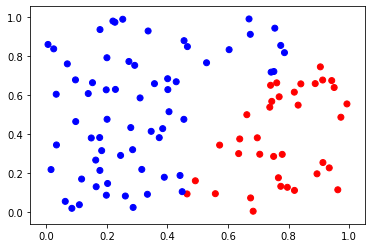

In [3]:
plt.scatter(x[:,0], x[:,1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]))

Before, implementing the kernel version of softmax, let me implement the linear one first to show that it works with a linear decision boundary, but fails with non-linear one.

In the cell below, I implement the simple softmax regression:

\begin{equation}
h(x) = \frac{1}{\sum _{j=1}^ k e^{\theta _ j \cdot x / \tau }} \begin{bmatrix}  e^{\theta _1 \cdot x / \tau } \\ e^{\theta _2 \cdot x / \tau } \\ \vdots \\ e^{\theta _ k \cdot x / \tau } \end{bmatrix}
\end{equation}

where $h(x)$ is the probability vector (over all classes $k$ classes) given the feature vector $x$ (dimension is $d$) and the parameter vector $\theta$ (dimension $k$ by $d$). $\tau$ is a hyperparameter that controls the variance of the distribution.

Remember that the cost function we want to minimize in order to find $\theta$ is:

\begin{equation}
J(\theta ) = -\frac{1}{n}\Bigg[\sum _{i=1}^ n \sum _{j=1}^{k} [[y^{(i)} == j]] \log {\frac{e^{\theta _ j \cdot x^{(i)} / \tau }}{\sum _{l=1}^ k e^{\theta _ l \cdot x^{(i)} / \tau }}}\Bigg] + \frac{\lambda }{2}\sum _{i=1}^{k}\sum _{j=0}^{d-1} \theta _{ij}^2
\end{equation}

and the gradient is:

\begin{equation}
\nabla _{\Theta _ j} J(\theta ) = -\frac{1}{\tau n} \sum _{i = 1} ^{n} [x^{(i)}([[y^{(i)} == j]] - p(y^{(i)} = j | x^{(i)}, \theta ))] + \lambda \theta _ j
\end{equation}

Here there is just two classes, but the formulation and code should work with more classes. 

The idea is then to use gradient descent with $n$ training examples $(x^{(i)}, y^{(i)})$ to find a $\theta$ that minimizes the cost function.

Notice I am using the same signature of the function you saw in MITx 6.86x Project 2.

In [4]:
def compute_logprobabilites(X, theta, temp_parameter):
    '''
    log probabilities is more stable, and we have to use them in compute_cost_function anyway, so 
      so I implement them here is take exp if needed
      
    X - (n,d)
    theta - (k, d)
    temp_parameter - scalar
    '''
    loge = (theta @ X.T) / temp_parameter
    c = np.max(loge, axis=0)
    loge = loge - c
    s = np.sum(np.exp(loge), axis=0)
    return loge - np.log(s)

def compute_probabilites(X, theta, temp_parameter):
    return np.exp(compute_logprobabilites(X, theta, temp_parameter))

def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    '''
    X - (n,d)
    Y - (n,)
    theta - (k,d)
    lambda_factor - scalar
    temp_parameter - scalar
    '''
    n = X.shape[0]
    logp = compute_logprobabilites(X, theta, temp_parameter)
    onehot = np.zeros_like(logp)
    onehot[Y, np.arange(onehot.shape[1])] = 1
    return -1./n * np.sum(onehot*logp) + lambda_factor / 2.0 * np.sum(theta**2)

def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    '''
    X - (n,d)
    Y - (n,)
    theta - (k,d)
    alpha - scalar (notice this is the learning rate here!)
    lambda_factor - scalar
    temp_parameter - scalar
    '''
    n = X.shape[0]
    k = theta.shape[0]
    onehot = np.zeros((k,n))
    onehot[Y, np.arange(n)] = 1
    p = compute_probabilites(X, theta, temp_parameter)
    grad = (-1./(temp_parameter*n) * (onehot - p) @ X + lambda_factor * theta)
    return theta - alpha * grad

def augment_feature_vector(X):
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    '''
    X - (n,d)
    Y - (n,)
    temp_parameter - scalar
    alpha - scalar (notice this is the learning rate here!)
    lambda_factor - scalar
    k - scalar
    num_iterations - scalar
    '''
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

Let us test with the data generated before:

In [5]:
theta, cost_function_history = softmax_regression(x, y, 1.0, alpha= 0.3, \
                                                  lambda_factor = 1.0e-4, k = 2, num_iterations = 1000)

Ploting the cost as a function of step number:

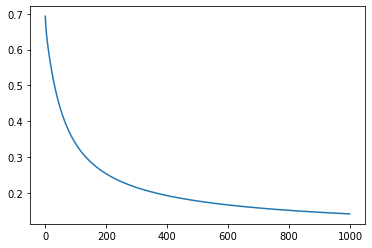

In [6]:
plt.plot(cost_function_history)

Let us plot the decision region and the traning point on top:

In [7]:
xx,yy=np.meshgrid(np.arange(0,1.05,0.05), np.arange(0,1.05,0.05))
xtest=np.vstack((xx.reshape(-1), yy.reshape(-1))).T
yhat=compute_probabilites(augment_feature_vector(xtest), theta, 1.0)

In [8]:
yhat=(yhat[1] > 0.5).astype(np.int)

(0, 1)

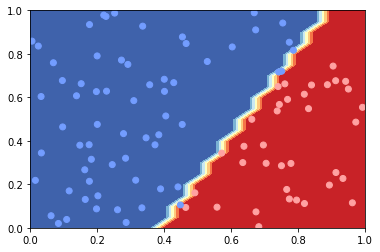

In [9]:
plt.contourf(xx,yy, yhat.reshape(xx.shape), cmap=plt.get_cmap("RdYlBu"))
plt.scatter(x[:,0], x[:,1], c=y, cmap=matplotlib.colors.ListedColormap(['#FFA2A2', "#739DFF"]))
plt.xlim((0,1))
plt.ylim((0,1))

Now, let me try another set of labels. One which is not linearly separable:

In [10]:
y=((x-0.5)**2 @ np.array([1,1]) > 0.15).astype(np.int)

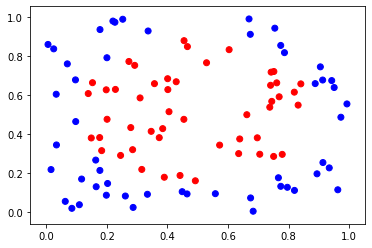

In [11]:
plt.scatter(x[:,0], x[:,1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]))

Let me check the same simple softmax with this data:

In [12]:
theta, cost_function_history = softmax_regression(x, y, 1.0, alpha= 0.3, \
                                                  lambda_factor = 1.0e-4, k = 2, num_iterations = 300)

notice that the cost does not drop much (pay attention to the y-axis - compare it to the previous plot):

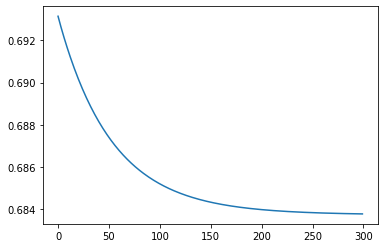

In [13]:
plt.plot(cost_function_history)

Let us see the decison regions:

In [14]:
xx,yy=np.meshgrid(np.arange(0,1.05,0.05), np.arange(0,1.05,0.05))
xtest=np.vstack((xx.reshape(-1), yy.reshape(-1))).T
yhat=compute_probabilites(augment_feature_vector(xtest), theta, 1.0)

In [15]:
yhat=(yhat[1] > 0.5).astype(np.int)

(0, 1)

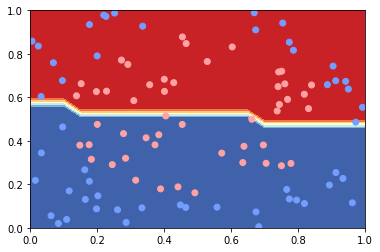

In [16]:
plt.contourf(xx,yy, yhat.reshape(xx.shape), cmap=plt.get_cmap("RdYlBu"))
plt.scatter(x[:,0], x[:,1], c=y, cmap=matplotlib.colors.ListedColormap(['#FFA2A2', "#739DFF"]))
plt.xlim((0,1))
plt.ylim((0,1))

pretty bad, hun?

An alternative to fix the issue is to use a kernel. I will show here a RBF, but the formulation is general.

The objective is:

\begin{equation}
J(\alpha)=-\frac{1}{n}\left[ \sum_{i=1}^{n}\sum_{j=1}^k [[y^{(i)}==j]]\text{log}\frac{e^{\sum_{m=1}^{n}\alpha_j^{(m)} K(x^{(m)},x^{(i)})/\tau}}{\sum_{l=1}^{k}e^{\sum_{m=1}^{n}\alpha_l^{(m)} K(x^{(m)},x^{(i)})/\tau}} \right] + \frac{\lambda}{2}\sum_{i=1}^{n}\sum_{j=1}^{k}\alpha_{ij}^2
\end{equation}

where the function $K$ is a kernel.

The gradient is then:

\begin{equation}
\nabla _{\alpha_j^{(m)}}J(\alpha)=-\frac{1}{n\tau}\left[ \sum_{i=1}^{n} \left( [[y^{(i)}==j]] - p(y^{(i)} = j|x^{(i)},\alpha_j) \right) K(x^{(m)},x^{(i)})  \right] +\lambda\alpha_j
\end{equation}

The code below uses Radial Basis Functions (RBF). Please, notice some of the comments in the code.

In [19]:
def rbf_kernel(X, Y, gamma):
    '''
    this is a vectorized implementation of RBF which is fast to run
    '''
    Xnorm = np.sum(X**2, axis=1)
    Ynorm = np.sum(Y**2, axis=1)
    cross = -2. * X @ Y.T
    return np.exp(-gamma *(Xnorm[:,None] + Ynorm[None,:] + cross))

def compute_logprobabilites(Xtrain, Ytrain, X, alpha, temp_parameter, gamma):
    '''
    Kernel methods are memory based methods this is whay in order to compute the probability
      of a input vector x (in the testing set for example) we need to give as input
      the training set (Xtrain, Ytrain). Have a look on the introduction section (pages 291 and
      page 292):
      
      https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf
      
      Xtrain - (n,d)
      Ytrain - (n,)
      X - (m, d) - (in training this is the same as Xtrain, but for testing it is different)
      alpha - (k,n)
      temp_parameter - scalar
      gamma - scalar
    '''
    km = rbf_kernel(Xtrain, X, gamma)
    loge = alpha @ (km/temp_parameter)
    c = np.max(loge, axis=0)
    loge = loge - c
    s = np.sum(np.exp(loge), axis=0)
    return loge - np.log(s)

def compute_probabilites(Xtrain, Ytrain, X, alpha, temp_parameter, gamma):
    return np.exp(compute_logprobabilites(Xtrain, Ytrain, X, alpha, temp_parameter, gamma))

def compute_cost_function(Xtrain, Ytrain, X, alpha, lambda_factor, temp_parameter, gamma):
    '''
      Xtrain - (n,d)
      Ytrain - (n,)
      X - (m, d) - (in training this is the same as Xtrain, but for testing it is different)
      alpha - (k,n)
      lambda_factor - scalar
      temp_parameter - scalar
      gamma - scalar
    '''
    n = X.shape[0]
    logp = compute_logprobabilites(Xtrain, Ytrain, X, alpha, temp_parameter, gamma)
    onehot = np.zeros_like(logp)
    onehot[Ytrain, np.arange(onehot.shape[1])] = 1
    return -1./n * np.sum(onehot*logp) + lambda_factor / 2.0 * np.sum(alpha**2)

def run_gradient_descent_iteration(X, Y, alpha, eta, lambda_factor, temp_parameter, gamma):
    '''
      Notice that there is no need here for a separate Xtrain, since running gradient descent is run
        only in training. In addition, I have a separate function to compute gradient, the next function.
        This is because I want to check that function. See the last function in this cell for some details.
    
      X - (n,d)
      Y - (n,)
      alpha - (k,n)
      eta - scalar (learning rate)
      lambda_factor - scalar
      temp_parameter - scalar
      gamma - scalar
    '''
    grad = gradient_cost_function(X, Y, alpha, lambda_factor, temp_parameter, gamma)
    return alpha - eta * grad

def gradient_cost_function(X, Y, alpha, lambda_factor, temp_parameter, gamma):
    '''
      X - (n,d)
      Y - (n,)
      alpha - (k,n)
      lambda_factor - scalar
      temp_parameter - scalar
      gamma - scalar
    '''
    n = X.shape[0]
    k = theta.shape[0]
    onehot = np.zeros((k,n))
    onehot[Y, np.arange(n)] = 1
    p = compute_probabilites(X, Y, X, alpha, temp_parameter, gamma)
    km = rbf_kernel(X, X, gamma)
    grad = (-1./(temp_parameter*n) * (onehot - p) @ km + lambda_factor * alpha)
    return grad

def augment_feature_vector(X):
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

def softmax_regression(X, Y, temp_parameter, eta, lambda_factor, k, num_iterations, gamma, alpha=None):
    X = augment_feature_vector(X)
    n = X.shape[0]
    if alpha is None:
        alpha = np.zeros([k, n])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, X, alpha, lambda_factor, \
                                                               temp_parameter, gamma))
        alpha = run_gradient_descent_iteration(X, Y, alpha, eta, lambda_factor, temp_parameter, gamma)
    return alpha, cost_function_progression

def eval_numerical_gradient(f, x):
    '''
    In order to check the gradient of the cost function, I implement here a finite difference function
      to compute the gradient numerically. This method is very inefficent to be used in training, but
      it is easy to implement and can be used to check the more efficient function gradient_cost_function above.
      
    For a nice introduction of the topic of gradient checking see: 
    
      http://cs231n.github.io/neural-networks-3/#gradcheck
    '''
    grad = np.zeros(x.shape)
    h = 1e-8

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = old_value - h # decrement by h
        fxmh = f(x) # evalute f(x - h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxph - fxmh) / (2.*h) # the slope
        it.iternext() # step to next dimension
    
    return grad

In [20]:
alpha, cost_function_history = softmax_regression(x, y, 1.0, eta= 0.06, \
                                                  lambda_factor = 1.0e-4, k = 2, num_iterations = 20000,\
                                                  gamma=0.8)

Let check the gradient implementation against the numerical implementation

In [21]:
ccf = lambda alpha : compute_cost_function(x,y,x,alpha,lambda_factor = 1.0e-5,\
                                           temp_parameter=1.0, gamma=0.01)
num_grad = eval_numerical_gradient(ccf, alpha)

In [22]:
grad = gradient_cost_function(x, y, alpha, lambda_factor=1.0e-5, temp_parameter= 1.0, gamma=0.01)

The relative error should be small:

In [24]:
np.max(np.abs((grad-num_grad)/np.maximum(np.abs(grad), np.abs(num_grad))))

3.9541115992738703e-07

This is pretty small, and that is great.

Let me see the decision regions:

In [26]:
xx,yy=np.meshgrid(np.arange(0,1.05,0.05), np.arange(0,1.05,0.05))
xtest=np.vstack((xx.reshape(-1), yy.reshape(-1))).T
yhat=compute_probabilites(x, y, xtest, alpha, 1.0, 0.8)

In [27]:
yhat=(yhat[1] > 0.5).astype(np.int)

(0, 1)

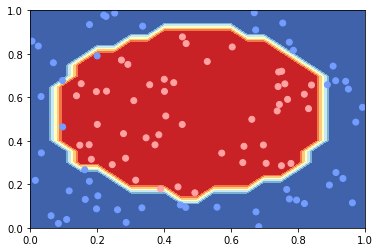

In [28]:
plt.contourf(xx,yy, yhat.reshape(xx.shape), cmap=plt.get_cmap("RdYlBu"))
plt.scatter(x[:,0], x[:,1], c=y, cmap=matplotlib.colors.ListedColormap(['#FFA2A2', "#739DFF"]))
plt.xlim((0,1))
plt.ylim((0,1))

Not bad.